Author: Mitch Fairweather

Research Paper that was followed: https://arxiv.org/pdf/1812.07606.pdf

# Importing all of the necessary packages. 

In [180]:
import os, math
from os import makedirs
from os.path import expanduser, exists, join

import argparse
import PIL
from PIL import Image
from queue import Queue
from threading import Thread

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

import numpy as np 
from numpy import random

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from tqdm import tqdm

import numpy as np


# The Data

The data that I will be using for analysis is from the Microsoft Malware Challenge hosted on Kaggle in 2015. The competition data can be found here: https://www.kaggle.com/c/malware-classification/data

Unzipping the data file leaves you with about 500gb of both the byte and assembly files. I will only be using the byte files, which there are about 10,000 files. A single byte file, before any transformations can be seen below.

In [178]:
file = open(r"C:\Users\fairwemr\ISA 480\FinalProject\01azqd4InC7m9JpocGv5.bytes", "rb")
byte = file.read(116)
print(byte) 

file.close()

b'00401000 E8 0B 00 00 00 E9 16 00 00 00 90 90 90 90 90 90\r\n00401010 B9 25 2B 56 00 FF 25 80 23 41 00 90 90 90 90 90\r\n'


# Step 1: Converting the 10868 byte files into RGB images. 

I found this github https://github.com/ncarkaci/binary-to-image/blob/master/binary2image.py for converting binary code to images, and used it as a starting point, and slightly tweaked it for my needs. 

#### Converting byte files binary


The function below will read in the binary data files, and basically converts the individual bytes into unicode format, and appends it to the "binary_values" array. 

In [169]:
def getBinaryData(filename):

    binary_values = []

    with open(filename, 'rb') as fileobject:

        # read file byte by byte
        data = fileobject.read(1) # initializes the reading byte values by reading the first

        while data != b'': # While the data object isn't empty 
            binary_values.append(ord(data)) #returns integer representing the Unicode code point of the character
            data = fileobject.read(1) # Reads the next line

    return binary_values # returning the binary values array 

#### Using Binary Arrays to Calculate Image Size


The function below sets up the data for converting to an image. Using the size of the binary file data, it calculates the necessary height and width of the image to be created. I used the same specifications found in the original paper. 

In [170]:
def get_size(data_length, width=None):

    if width is None: # if the user doesn't pass in a hardcoded width value. 

        size = data_length

        if (size < 10240):
            width = 32
        elif (10240 <= size <= 10240 * 3):
            width = 64
        elif (10240 * 3 <= size <= 10240 * 6):
            width = 128
        elif (10240 * 6 <= size <= 10240 * 10):
            width = 256
        elif (10240 * 10 <= size <= 10240 * 20):
            width = 384
        elif (10240 * 20 <= size <= 10240 * 50):
            width = 512
        elif (10240 * 50 <= size <= 10240 * 100):
            width = 768
        else:
            width = 1024

        height = int(size / width) + 1

    else:
        width  = int(math.sqrt(data_length)) + 1
        height = width

    return (width, height)

#### Saving the greyscale or RGB image as a png file

The below function, when called, will save the converted binary to image file into a .png file. 

In [171]:
def save_file(filename, data, size, image_type):

    try:
        image = Image.new(image_type, size)
        image.putdata(data)

        # setup output filename
        dirname     = os.path.dirname(filename)
        name, _     = os.path.splitext(filename)
        name        = os.path.basename(name)
        imagename   = dirname + os.sep + image_type + os.sep + name + '.png'
        os.makedirs(os.path.dirname(imagename), exist_ok=True)

        image.save(imagename)
        print('The file', imagename, 'saved.')
    except Exception as err:
        print(err)

#### Creating Grey Scale Image from binary values

The below function converts the binary files into a grescale image. I have commented out the save_file portion, as I will only be using the RGB png files for training and testing. 

In [172]:
def createGreyScaleImage(filename, width=None):
    
    greyscale_data  = getBinaryData(filename)
    size            = get_size(len(greyscale_data), width)
    #save_file(filename, greyscale_data, size, 'L')

#### Creating RGB Image from binary values

The below function is the important one, converting the 24 bit binary data into RGB format, and then saving the file as a RGB png file. 

In [173]:
def createRGBImage(filename, width=None):
    """
    Create RGB image from 24 bit binary data 8bit Red, 8 bit Green, 8bit Blue
    :param filename: image filename
    """
    index = 0
    rgb_data = []

    # Read binary file
    binary_data = getBinaryData(filename)

    # Create R,G,B pixels
    while (index + 3) < len(binary_data):
        R = binary_data[index]
        G = binary_data[index+1]
        B = binary_data[index+2]
        index += 3
        rgb_data.append((R, G, B))

    size = get_size(len(rgb_data), width)
    save_file(filename, rgb_data, size, 'RGB')

# Step 2: Creating my Data 

#### Converting all of my byte files to RGB images


The below function is the wrapper I wrote for all of the above functions. It gets the binary data, finds the correct image size based on the file size, and then converts it to an RGB image which is saved. 

In [174]:
def main(filename):
    Binary_Values = getBinaryData(filename)
    size = get_size(data_length = len(Binary_Values))
    
    rgbImage = createRGBImage(filename)

    return Binary_Values

With over 10868 binary files, I iterated over all of the files in the specified directory and called the main function at each iteration. The end result from this is a folder in the trainBytes directory called RGB holding 10868 total png files. I made the block below a markdown cell to prevent it from running again, as it took nearly 24 hours the initial pass through. 

In [ ]:
directory = r"C:\Users\mitch\ISA480FinalProject\trainBytes"
for filename in os.listdir(directory):
    main(filename = directory + os.sep + filename)


#### Sample images

Below are just two examples of what these RGB images created from the binary code look like. As you can see, to the naked eye there is not much variation or interesting areas. 

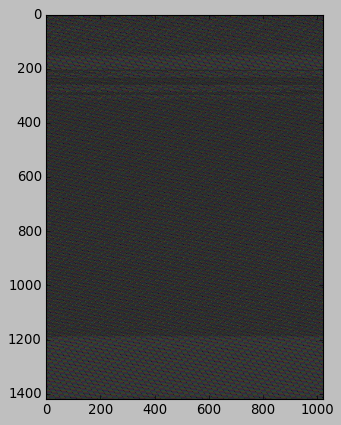

In [176]:
img=mpimg.imread(r'C:\Users\fairwemr\ISA 480\FinalProject\RGB\0A32eTdBKayjCWhZqDOQ.png')
imgplot = plt.imshow(img)
plt.show()

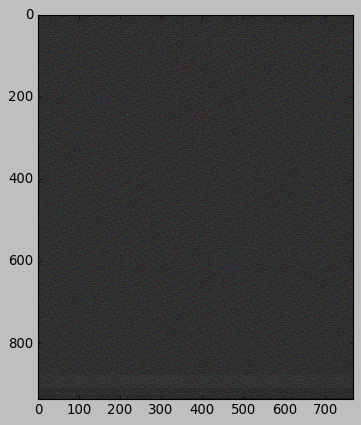

In [177]:
img=mpimg.imread(r'C:\Users\fairwemr\ISA 480\FinalProject\RGB\8Z5zugCOx3cTB6ikpbSq.png')
imgplot = plt.imshow(img)
plt.show()

#### Bringing in Data Labels

From the Kaggle Website, there is another csv file that holds each file's ID along with its malware class noted by a 1 through 9 integer. 

In [2]:
train_malware = pd.read_csv(r"C:\Users\fairwemr\ISA 480\FinalProject\trainLabels.csv")
train_malware

Id  Class
0      01kcPWA9K2BOxQeS5Rju      1
1      04EjIdbPV5e1XroFOpiN      1
2      05EeG39MTRrI6VY21DPd      1
3      05rJTUWYAKNegBk2wE8X      1
4      0AnoOZDNbPXIr2MRBSCJ      1
...                     ...    ...
10863  KFrZ0Lop1WDGwUtkusCi      9
10864  kg24YRJTB8DNdKMXpwOH      9
10865  kG29BLiFYPgWtpb350sO      9
10866  kGITL4OJxYMWEQ1bKBiP      9
10867  KGorN9J6XAC4bOEkmyup      9

[10868 rows x 2 columns]

Below, I am matching up the ID's from kaggles label file with the PNG file names. The output is the original label file, with a third column that holds the image path for each observation. 

In [3]:
train_folder = r"C:\Users\fairwemr\ISA 480\FinalProject\RGB"
train_malware['image_path'] = train_malware.apply( lambda x: (train_folder + os.sep +  x["Id"] + ".png"), axis=1)

pd.options.display.max_colwidth = 100
train_malware

Id  Class  \
0      01kcPWA9K2BOxQeS5Rju      1   
1      04EjIdbPV5e1XroFOpiN      1   
2      05EeG39MTRrI6VY21DPd      1   
3      05rJTUWYAKNegBk2wE8X      1   
4      0AnoOZDNbPXIr2MRBSCJ      1   
...                     ...    ...   
10863  KFrZ0Lop1WDGwUtkusCi      9   
10864  kg24YRJTB8DNdKMXpwOH      9   
10865  kG29BLiFYPgWtpb350sO      9   
10866  kGITL4OJxYMWEQ1bKBiP      9   
10867  KGorN9J6XAC4bOEkmyup      9   

                                                                image_path  
0      C:\Users\fairwemr\ISA 480\FinalProject\RGB\01kcPWA9K2BOxQeS5Rju.png  
1      C:\Users\fairwemr\ISA 480\FinalProject\RGB\04EjIdbPV5e1XroFOpiN.png  
2      C:\Users\fairwemr\ISA 480\FinalProject\RGB\05EeG39MTRrI6VY21DPd.png  
3      C:\Users\fairwemr\ISA 480\FinalProject\RGB\05rJTUWYAKNegBk2wE8X.png  
4      C:\Users\fairwemr\ISA 480\FinalProject\RGB\0AnoOZDNbPXIr2MRBSCJ.png  
...                                                                    ...  
10863  C:\Users\fairwemr\ISA 480\FinalProject\RGB\KFrZ0Lop1WDGwUtkusCi.png  
10864  C:\Users\fairwemr\ISA 480\FinalProject\RGB\kg24YRJTB8DNdKMXpwOH.png  
10865  C:\Users\fairwemr\ISA 480\FinalProject\RGB\kG29BLiFYPgWtpb350sO.png  
10866  C:\Users\fairwemr\ISA 480\FinalProject\RGB\kGITL4OJxYMWEQ1bKBiP.png  
10867  C:\Users\fairwemr\ISA 480\FinalProject\RGB\KGorN9J6XAC4bOEkmyup.png  

[10868 rows x 3 columns]

# Step 3: Preparing Data for Modeling

#### Creating Training and testing data partitions

Getting the Data ready for feeding in to the model.  

In [4]:
target_labels = train_malware['Class']

In [5]:
train_data  = np.array([img_to_array(load_img(img, target_size=(299, 299))) for img in train_malware[r'image_path'].values.tolist()]).astype('float32')

In [6]:
x_train, x_validation, y_train, y_validation = train_test_split(train_data, target_labels, test_size=0.2, stratify=np.array(target_labels), random_state=100)

In the original paper, their final model was based on the Inception V1 model, which used a resized image of 224x224. However, the inception V1 model is no longer in use from what I can find, so I started with the inception V3 model as my starting point. The target image size for this model is 299x299. 

In [7]:
print ('x_train shape = ', x_train.shape)
print ('x_validation shape = ', x_validation.shape)

x_train shape =  (8694, 299, 299, 3)
x_validation shape =  (2174, 299, 299, 3)


#### Visualization of Training and testing data sets

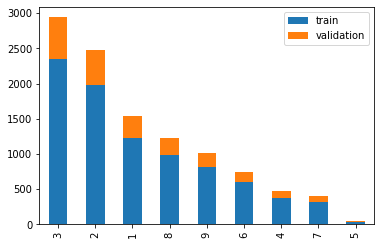

In [8]:
# Calculate the value counts for train and validation data and plot to show the partitioning of the data
data = y_train.value_counts().sort_index().to_frame()   # this creates the data frame with train numbers
data.columns = ['train']
data['validation'] = y_validation.value_counts().sort_index().to_frame()   # add the validation numbers
new_plot = data[['train','validation']].sort_values(['train']+['validation'], ascending=False)   # sort the data
new_plot.plot(kind='bar', stacked=True)
plt.show()


#### Creating the Response variable as one-hot dummy variables

In [9]:
y_train = pd.get_dummies(y_train.reset_index(drop=True))
y_validation = pd.get_dummies(y_validation.reset_index(drop=True))

#### Creating image generators for training the keras models. 

For most applications of image classification, many use a variety of resizing, zoom, rotation, etc. of the image to make the neural network able to pick up more on the individual pixel patterns. However, because the original paper made no mention of their resizing technique, I was unsure of whether to follow that path. Additionally, I used the logic that because our images are created from binary code, and not humans taking pictures of objects at different angles for example, all of those image manipulations aren't as applicable to classifying RGB images of malware binary code as other image classification techniques. 

In [10]:
# Create train generator.
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, shuffle=True, batch_size=100, seed=10)

In [11]:
# Create validation generator
val_datagen = ImageDataGenerator()
val_generator = train_datagen.flow(x_validation, y_validation, shuffle=True, batch_size=10, seed=10)

# Inception V3 Model

In the paper, they claimed that their technique could be applied to a variety of pre-trained neural networks. Their "final"model, however, was based on the pre-trained inception V1. This model is no longer in use, however the inception V3 is. Thus, this is the first model I tried to retrain. 

#### Loading in the Base Inception V3 Model

In [12]:
# Get the InceptionV3 model
#include_top = false to allow me to create my own pooling and output layer 
base_inception_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(299, 299, 3))

#### Adding layers to the pre-trained model

From my limited, but growing knowledge, global average pooling layers are used to help prevent overfitting. Nearly every resource I found to retrain inception models include adding this layer, and it aligned with my goals, so I did as well. 

In [13]:
# Add a global spatial average pooling layer.
x = base_inception_model.output
x = GlobalAveragePooling2D()(x)

Many of the resources I found were adding a dense layer with far more nodes than the 512 value I ended on, some upwards of 5000. I tried this at first, realized it was taking far too long to retrain, and was seeing abismal results all around on both the training and testing data. After a lot of research, many people recommended lowering this value to between 400-800 to improve performance on both partitions and speed up training.  

In [14]:
# Add a fully-connected layer and a logistic layer with 9 outputs, one for each class of malware
x = Dense(512, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

In [15]:
# The model we will train
inceptionV3Model = Model(inputs = base_inception_model.input, outputs = predictions)


#### Freezing base layers from being trained

The original paper was not very clear on which layers of the neural network they decided to train and which they kept the pre-trained weights. They mentioned that they froze everything but the last few layers, and explicitly said they trained the final pooling layer. Because the final pooling layer was one that I added myself, I froze all of the base model layers, and only trained the pooling layer I created, the dense layer, and the output layer. 

In [16]:
# first: train only the top layers i.e. freeze all convolutional InceptionV3 layers
for layer in base_inception_model.layers:
    layer.trainable = False


In [17]:
print(inceptionV3Model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

#### Training the Model

In [18]:
# Compile with Adam
inceptionV3Model.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])


After seeing how terrible the performance was, I tried increasing my learning rate, but saw no impact. I started at .0001, and increased to the current .001. Performance was slightly better, but still far from satisfactory. 

In [19]:
checkpoint = ModelCheckpoint("inception_v3_1.h5", monitor='val_acc', verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=2, mode='auto')

inceptionV3Hist = inceptionV3Model.fit_generator(generator= train_generator,
                                     validation_data = val_generator,
                                     epochs = 10,
                                     callbacks=[checkpoint,early])

Epoch 1/10
87/87 [==============================] - 1201s 14s/step - loss: 0.7889 - accuracy: 0.7473 - val_loss: 15.0749 - val_accuracy: 0.0396
Epoch 2/10
87/87 [==============================] - 1198s 14s/step - loss: 0.5040 - accuracy: 0.8430 - val_loss: 13.7417 - val_accuracy: 0.0313
Epoch 3/10
87/87 [==============================] - 1197s 14s/step - loss: 0.3945 - accuracy: 0.8749 - val_loss: 12.5104 - val_accuracy: 0.0695
Epoch 4/10
87/87 [==============================] - 1198s 14s/step - loss: 0.3710 - accuracy: 0.8827 - val_loss: 20.5829 - val_accuracy: 0.0690
Epoch 5/10
87/87 [==============================] - 1197s 14s/step - loss: 0.3303 - accuracy: 0.8929 - val_loss: 23.1406 - val_accuracy: 0.0672
Epoch 6/10
87/87 [==============================] - 1212s 14s/step - loss: 0.2823 - accuracy: 0.9086 - val_loss: 34.0384 - val_accuracy: 0.0690
Epoch 7/10
87/87 [==============================] - 1200s 14s/step - loss: 0.2553 - accuracy: 0.9167 - val_loss: 29.0741 - val_accuracy:

In [43]:
inceptionV3Model.save(r"C:\Users\fairwemr\ISA 480\FinalProject\inceptionV3Model.h5")
inceptionV3Hist.model.save(r"C:\Users\fairwemr\ISA 480\FinalProject\inceptionV3Hist.h5")

### Results from the Inception V3 Model

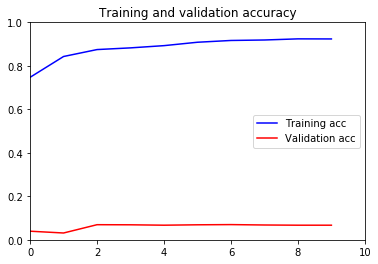

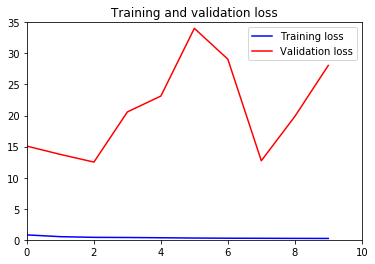

In [61]:
inceptionV3Hist_acc = inceptionV3Hist.history['accuracy']
inceptionV3Hist_val_acc = inceptionV3Hist.history['val_accuracy']
inceptionV3Hist_loss = inceptionV3Hist.history['loss']
inceptionV3Hist_val_loss = inceptionV3Hist.history['val_loss']

inceptionV3Hist_epochs = range(len(inceptionV3Hist_acc))

plt.axis([0, 10, 0, 1])


plt.plot(inceptionV3Hist_epochs, inceptionV3Hist_acc, 'b', label='Training acc')
plt.plot(inceptionV3Hist_epochs, inceptionV3Hist_val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(inceptionV3Hist_epochs, inceptionV3Hist_loss, 'b', label='Training loss')
plt.plot(inceptionV3Hist_epochs, inceptionV3Hist_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.axis([0, 10, 0, 35])


plt.show()

#### Discussion of Results

As you can see, the performance on the inception V3 model is absolutely terrible. I was very perplexed as to how the model could overfit the training data so much to the point where accuracy on the testing data was basically zero. The two data sets shouldn't be that different, where even if it is overfit I would expect halfway decent performance on the testing. Obviously not the case.

After hours of searching, rerunning the model with different image augmentations, learning rates, even different architectures and layers, this was the BEST performance I achieved. Many of the preliminary models had training accuracies of 20%. The only solution I could find from other people having similar issues was that the model itself is just not well suited to what I need. Many encouraged trying the VGG16 model, which was also mentioned in the original paper, as even without fine tuning parameters, performance was much better.

# VGG16 Model - Attempt 1

#### Reading in the base VGG16 model

In [22]:
#Get  the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#### Adding layers to the base model

To prevent the need to create an entirely new data set of resized images, I created a new input layer for the VGG16 model to feed in images with the shape 299x299. The normal model uses an image size of 224x224. I attempted this at first when experimenting with it, but saw no impact on final results by using the same data sets used to retrain the Inception V3 model for retraining the VGG16 model. 

In [23]:
#Creating my own input layer (299x299x3)
input = Input(shape=(299,299,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

In [24]:
#Add the fully-connected layers 
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(512, activation='relu', name='fc1')(y)
y = Dense(512, activation='relu', name='fc2')(y)
y = Dense(9, activation='softmax', name='predictions')(y)

In [25]:
#Create your own model 
vgg16model = Model(input=input, output=y)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
vgg16model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               21234176  
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
predictions (Dense)          (None, 9)                 4617      
Total params: 36,216,137
Trainable params: 36,216,137
Non-trainable params: 0
_______________________________________________

#### Freezing the base layers from being trained

Similar to retraining the inception V3 model, I also froze all of the base layers and chose to only train the final few layers that I created. 

In [26]:
for layer in vgg16model.layers[:-4]:
    layer.trainable = False
    
for layer in vgg16model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000000B71367A648> False
<keras.engine.training.Model object at 0x000000B713669908> False
<keras.layers.core.Flatten object at 0x000000B71369F208> True
<keras.layers.core.Dense object at 0x000000B71369F1C8> True
<keras.layers.core.Dense object at 0x000000B71369F388> True
<keras.layers.core.Dense object at 0x000000B71369FB88> True


In [27]:
vgg16model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               21234176  
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
predictions (Dense)          (None, 9)                 4617      
Total params: 36,216,137
Trainable params: 21,501,449
Non-trainable params: 14,714,688
______________________________________

#### Training the Model

In [28]:
opt = Adam(lr=0.001)
vgg16model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [29]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=2, mode='auto')
vgg16modelHist = vgg16model.fit_generator(
                           generator=train_generator, 
                           validation_data= val_generator, 
                           epochs=10,
                           callbacks=[checkpoint,early], 
                           )

Epoch 1/10
87/87 [==============================] - 1562s 18s/step - loss: 0.9233 - accuracy: 0.8007 - val_loss: 0.3266 - val_accuracy: 0.8855
Epoch 2/10
87/87 [==============================] - 1540s 18s/step - loss: 0.2224 - accuracy: 0.9340 - val_loss: 0.0208 - val_accuracy: 0.9154
Epoch 3/10
87/87 [==============================] - 1543s 18s/step - loss: 0.1327 - accuracy: 0.9599 - val_loss: 0.0397 - val_accuracy: 0.9264
Epoch 4/10
87/87 [==============================] - 1529s 18s/step - loss: 0.0753 - accuracy: 0.9770 - val_loss: 0.3092 - val_accuracy: 0.9319
Epoch 5/10
87/87 [==============================] - 1525s 18s/step - loss: 0.0468 - accuracy: 0.9867 - val_loss: 0.0017 - val_accuracy: 0.9319
Epoch 6/10
87/87 [==============================] - 1541s 18s/step - loss: 0.0419 - accuracy: 0.9879 - val_loss: 8.6230e-04 - val_accuracy: 0.9333
Epoch 7/10
87/87 [==============================] - 1549s 18s/step - loss: 0.0331 - accuracy: 0.9901 - val_loss: 0.0013 - val_accuracy: 0.

In [42]:
vgg16model.save(r"C:\Users\fairwemr\ISA 480\FinalProject\vgg16model.h5")
vgg16modelHist.model.save(r"C:\Users\fairwemr\ISA 480\FinalProject\vgg16modelHist.h5")

### Results from VGG16 - Attempt 1

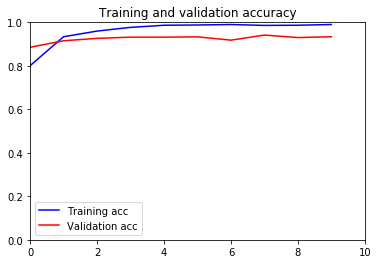

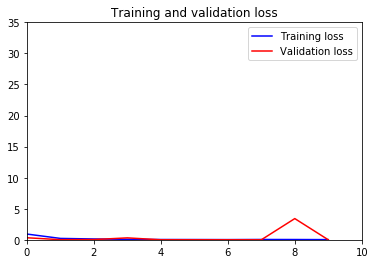

In [62]:
vgg16modelHist_acc = vgg16modelHist.history['accuracy']
vgg16modelHist_val_acc = vgg16modelHist.history['val_accuracy']
vgg16modelHist_loss = vgg16modelHist.history['loss']
vgg16modelHist_val_loss = vgg16modelHist.history['val_loss']

vgg16modelHist_epochs = range(len(vgg16modelHist_acc))

plt.axis([0, 10, 0, 1])

plt.plot(vgg16modelHist_epochs, vgg16modelHist_acc, 'b', label='Training acc')
plt.plot(vgg16modelHist_epochs, vgg16modelHist_val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(vgg16modelHist_epochs, vgg16modelHist_loss, 'b', label='Training loss')
plt.plot(vgg16modelHist_epochs, vgg16modelHist_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.axis([0, 10, 0, 35])


plt.show()

#### Analysis of VGG16 Model Results

As you can see, the model quickly overfit the training data, reaching an overall accuracy of essentially 1 by the end of training. However, unlike the inception V3 model, I was still able to obtain fairly decent performance on the validation data. Ovearll, I am pleased that I am able to achieve somewhat close to similar results as the original paper, which claimed accuracies of 99% on testing data. I do believe there is room for improvement. To prevent such overfitting, I want to retrain the model using a lower learning rate. 

# VGG Model - Attempt 2

#### Reading in the base VGG16 model

In [32]:
#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#### Adding layers to the base model

In [33]:
#Create your own input format (here 299x299x3)
input = Input(shape=(299,299,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

In [34]:
#Add the fully-connected layers 
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(512, activation='relu', name='fc1')(y)
y = Dense(512, activation='relu', name='fc2')(y)
y = Dense(9, activation='softmax', name='predictions')(y)

In [35]:
#Create your own model 
vgg16modelV2 = Model(input=input, output=y)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
vgg16modelV2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               21234176  
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
predictions (Dense)          (None, 9)                 4617      
Total params: 36,216,137
Trainable params: 36,216,137
Non-trainable params: 0
_______________________________________________

#### Freezing the base layers from being trained

In [36]:
for layer in vgg16modelV2.layers[:-4]:
    layer.trainable = False
    
for layer in vgg16modelV2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000000B7138E9C08> False
<keras.engine.training.Model object at 0x000000B7138D3E08> False
<keras.layers.core.Flatten object at 0x000000B71391B248> True
<keras.layers.core.Dense object at 0x000000B71391B208> True
<keras.layers.core.Dense object at 0x000000B71391B3C8> True
<keras.layers.core.Dense object at 0x000000B71391B588> True


In [37]:
vgg16modelV2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               21234176  
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
predictions (Dense)          (None, 9)                 4617      
Total params: 36,216,137
Trainable params: 21,501,449
Non-trainable params: 14,714,688
______________________________________

#### Training the Model

In [38]:
opt = Adam(lr=0.0001)
vgg16modelV2.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [39]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=2, mode='auto')
vgg16modelV2Hist = vgg16modelV2.fit_generator(
                           generator=train_generator, 
                           validation_data= val_generator, 
                           epochs=10,
                           callbacks=[checkpoint,early], 
                           )

Epoch 1/10
87/87 [==============================] - 1529s 18s/step - loss: 0.5072 - accuracy: 0.8482 - val_loss: 0.4219 - val_accuracy: 0.8983
Epoch 2/10
87/87 [==============================] - 1540s 18s/step - loss: 0.1959 - accuracy: 0.9418 - val_loss: 0.0049 - val_accuracy: 0.9213
Epoch 3/10
87/87 [==============================] - 1538s 18s/step - loss: 0.1024 - accuracy: 0.9723 - val_loss: 1.2242 - val_accuracy: 0.9080
Epoch 4/10
87/87 [==============================] - 1518s 17s/step - loss: 0.0640 - accuracy: 0.9831 - val_loss: 0.0441 - val_accuracy: 0.9370
Epoch 5/10
87/87 [==============================] - 1525s 18s/step - loss: 0.0339 - accuracy: 0.9924 - val_loss: 0.0053 - val_accuracy: 0.9420
Epoch 6/10
87/87 [==============================] - 1540s 18s/step - loss: 0.0249 - accuracy: 0.9946 - val_loss: 0.0013 - val_accuracy: 0.9430
Epoch 7/10
87/87 [==============================] - 1528s 18s/step - loss: 0.0114 - accuracy: 0.9986 - val_loss: 0.2620 - val_accuracy: 0.9443

In [41]:
vgg16modelV2.save(r"C:\Users\fairwemr\ISA 480\FinalProject\vgg16modelV2.h5")
vgg16modelV2Hist.model.save(r"C:\Users\fairwemr\ISA 480\FinalProject\vgg16modelV2Hist.h5")

### Results from VGG16 Model attempt 2

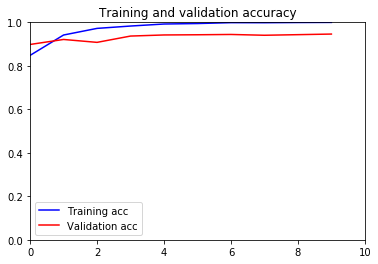

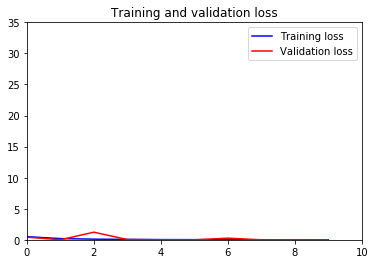

In [63]:
vgg16modelV2Hist_acc = vgg16modelV2Hist.history['accuracy']
vgg16modelV2Hist_val_acc = vgg16modelV2Hist.history['val_accuracy']
vgg16modelV2Hist_loss = vgg16modelV2Hist.history['loss']
vgg16modelV2Hist_val_loss = vgg16modelV2Hist.history['val_loss']

vgg16modelV2Hist_epochs = range(len(vgg16modelV2Hist_acc))

plt.axis([0, 10, 0, 1])

plt.plot(vgg16modelV2Hist_epochs, vgg16modelV2Hist_acc, 'b', label='Training acc')
plt.plot(vgg16modelV2Hist_epochs, vgg16modelV2Hist_val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(vgg16modelV2Hist_epochs, vgg16modelV2Hist_loss, 'b', label='Training loss')
plt.plot(vgg16modelV2Hist_epochs, vgg16modelV2Hist_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.axis([0, 10, 0, 35])


plt.show()

#### Analysis of results 

To my surprise, lowering the learning rate had only a minimal impact on the overfitting of the training data. Looking at the top graph plotting the training and validation accuracy, the training accuracy was "smoother" ie it took longer to reach an accuracy of 1. Based on the two attempts to retrain the model, it looks like an epoch of 1 might actually provide the best and most stable performance across the two data sets. 

## Final VGG16 Model 

#### Reading in the Base Model

In [64]:
#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#### Adding layers to the base model

In [65]:
#Create your own input format (here 299x299x3)
input = Input(shape=(299,299,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

In [66]:
#Add the fully-connected layers 
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(512, activation='relu', name='fc1')(y)
y = Dense(512, activation='relu', name='fc2')(y)
y = Dense(9, activation='softmax', name='predictions')(y)

In [67]:
#Create your own model 
vgg16modelFinal = Model(input=input, output=y)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
vgg16modelFinal.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               21234176  
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
predictions (Dense)          (None, 9)                 4617      
Total params: 36,216,137
Trainable params: 36,216,137
Non-trainable params: 0
_______________________________________________

#### Freezing the base layers from being trained

In [68]:
for layer in vgg16modelFinal.layers[:-4]:
    layer.trainable = False
    
for layer in vgg16modelFinal.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000000B73F40F8C8> False
<keras.engine.training.Model object at 0x000000B73F3F9D88> False
<keras.layers.core.Flatten object at 0x000000B73F556948> True
<keras.layers.core.Dense object at 0x000000B73F556888> True
<keras.layers.core.Dense object at 0x000000B73F556C48> True
<keras.layers.core.Dense object at 0x000000B73F55D448> True


In [69]:
vgg16modelFinal.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               21234176  
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
predictions (Dense)          (None, 9)                 4617      
Total params: 36,216,137
Trainable params: 21,501,449
Non-trainable params: 14,714,688
______________________________________

#### Training the model

In [70]:
opt = Adam(lr=0.0001)
vgg16modelFinal.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [71]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=2, mode='auto')
vgg16modelFinalHist = vgg16modelFinal.fit_generator(
                           generator=train_generator, 
                           validation_data= val_generator, 
                           epochs=1,
                           callbacks=[checkpoint,early], 
                           )

Epoch 1/1
87/87 [==============================] - 1582s 18s/step - loss: 0.5388 - accuracy: 0.8393 - val_loss: 1.2721 - val_accuracy: 0.8997


In [72]:
vgg16modelFinal.save(r"C:\Users\fairwemr\ISA 480\FinalProject\vgg16modelFinal.h5")
vgg16modelFinalHist.model.save(r"C:\Users\fairwemr\ISA 480\FinalProject\vgg16modelFinalHist.h5")

## Results from Final Model

#### Getting predictions from Final Model

In [136]:
predictions =  vgg16modelFinal.predict(x_validation)

In [137]:
y_validation_np =  y_validation.to_numpy()

#### Confusion matrix of the prediction errors

The function below was found from: https://stackoverflow.com/questions/44054534/confusion-matrix-error-when-array-dimensions-are-of-size-3

In [138]:
def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)



    plt.tight_layout()


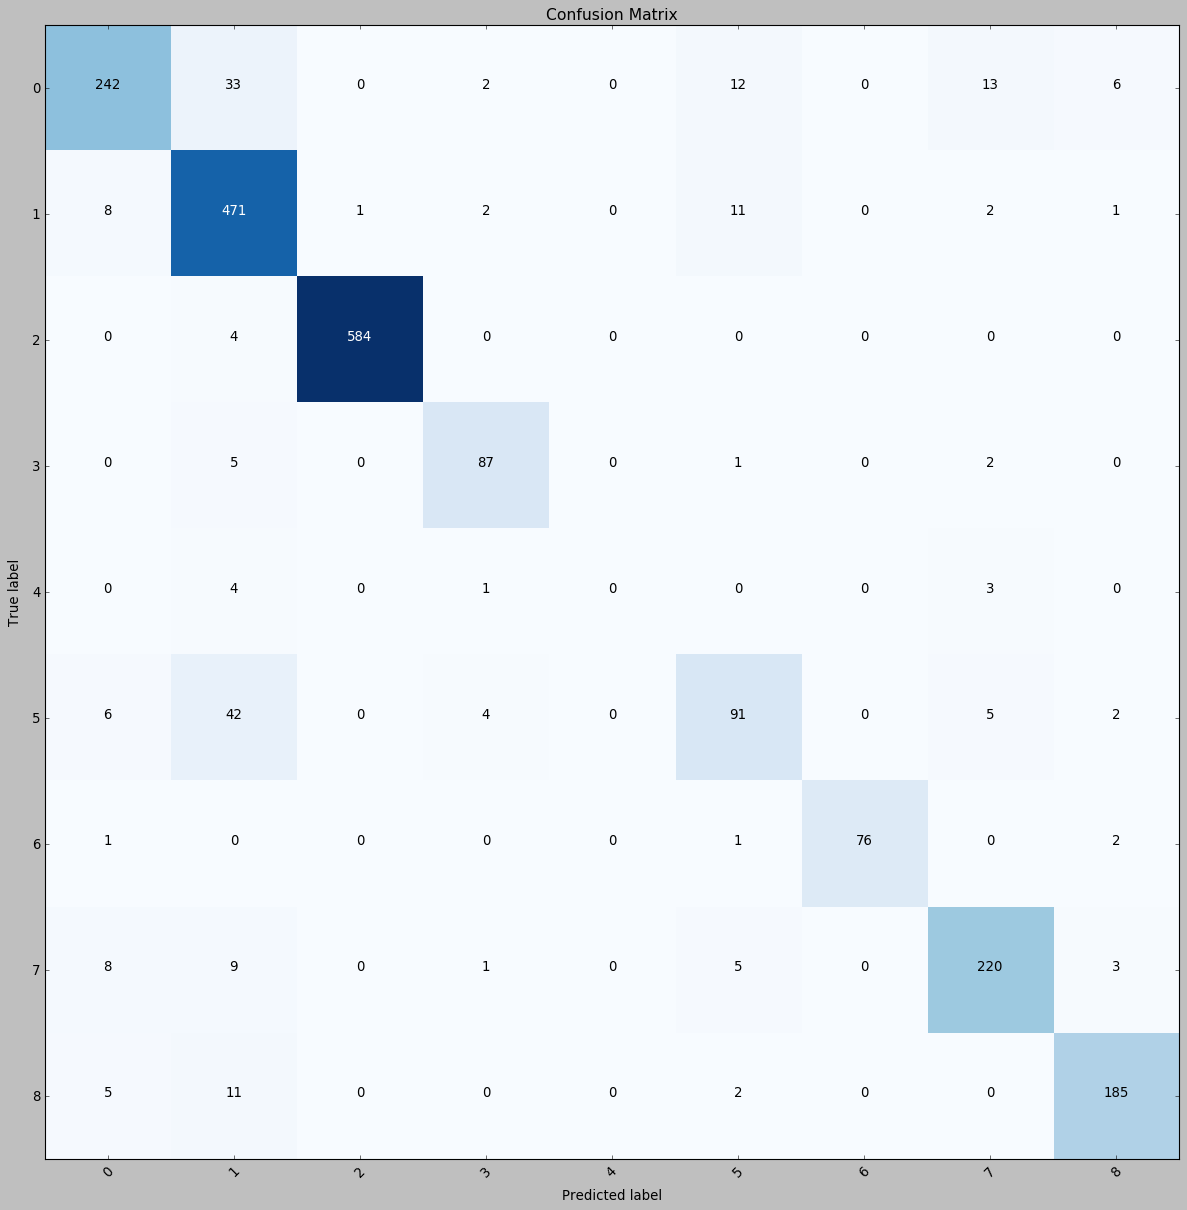

In [141]:
# Plot Confusion Matrix
plt.style.use('classic')
plt.figure(figsize=(15,15))
pretty_print_conf_matrix(y_validation_np.argmax(axis=1), predictions.argmax(axis=1), 
                         classes= ['0',' 1', '2', '3', '4', '5', '6', '7', '8'],
                         normalize=False, 
                         title='Confusion Matrix')

As you can see, the final model did a very good job at classifying the validation images in to their proper category. As expected there is some error in this, but overall I am pleased. I found it interesting that the model had trouble with predicting the label 1 category. As you can see, it predicted "1" for quite a few wrong categories, especially when the ground truth was a label of 5.

#### Metrics on prediction performance

In [140]:
 # Show Precision, Recall, F-1 Score
rpt = classification_report(y_validation_np.argmax(axis=1), predictions.argmax(axis=1))
rpt = rpt.replace('avg / total', '      avg')
rpt = rpt.replace('support', 'N Obs')
print(rpt)

              precision    recall  f1-score   N Obs

           0       0.90      0.79      0.84       308
           1       0.81      0.95      0.88       496
           2       1.00      0.99      1.00       588
           3       0.90      0.92      0.91        95
           4       0.00      0.00      0.00         8
           5       0.74      0.61      0.67       150
           6       1.00      0.95      0.97        80
           7       0.90      0.89      0.90       246
           8       0.93      0.91      0.92       203

    accuracy                           0.90      2174
   macro avg       0.80      0.78      0.79      2174
weighted avg       0.90      0.90      0.90      2174



## Next Steps

There are several other areas the paper explored that I have been unable to mainly because of computational ability. I'll walk through several below. 

1. The paper explored the process of training a smaller neural network from scratch to compare it to the pre-trained model from keras. I do not have the computational ability to explore this unfortunately. However, the paper was unable to reach a level of performance from the model trained from scratch that compared to the pre-trained keras model. Because of this, I am not too worried that not building one from scratch will change my final conclusions. 

2. The original paper also explored instead of classifying malware based on their family, but instead classify them either as a benign file or a malicious file. Unfortunately this isn't possible witht the data that I have. The binary files that I have access to are only malicious files, and thus I am unable to explore this. I do think this area would be more interesting and particularly useful as a whole. At least for me, I care more about determining whether or not file is malicious than just determining what family of malware it falls in. 

3. The original paper also explored several other models, including SVM's with a radial kernel and linear kernel. I explored this area, and how I could apply the type of data that I had to these types of classification models. Unfortunately, I wasn't quite able to figure out how this could be done in the time that I have to work and my current level of knowledge. I will continue to try and figure this problem out, as the area of image classification is extremely fascinating to me. 

4. I recognize that the validation performance of my data is not quite on par with the reported performance of the paper (accuracy of 90% for my final model versus 99% in the paper). Additionally, I recognize that the discrepency between training performance at 99% and validation at 90% would certainly indicate overfitting. If I had the knowledge on what layers to add to the VGG16 model to help prevent this, I think I could boost overall performance.

## Final Thoughts

Overall, I am very pleased with how much I was able to accomplish in working through this paper. I have never touched image classification before in any class or personal project, so I had to start from scratch in terms of learning how this is done. 

Additionally, this is my first time using Keras pre-trained models for transfer learning, and I am incredibly impressed at how simple the interface is as well as how accurate one can get a pre-trained model. Most of these models were trained on images like dogs, cats, cereal boxes, etc., so the fact that they can perform so well with just a little fine tuning on RGB images of malware byte code is very cool. 

I recognize there are parts of the paper I was unable to touch. Although I tried to hit the major components, there were a lot of smaller details that were very fascinating and certainly worth exploring further on my own. If I can find a good data set that has both malicious and benign byte code files, then I will certainly retrain these models for binary malware classification. 

Finally, I would love to explore some of the other machine learning models on this data, particularly their use of the XGBTree algorithm combined with PCA. I find their decision to keep only 80 components out of the original 50176 predictors to be concerning, especially with no discussion as to how much variation was kept in those 80. An overall accuracy of 96% on the XGBTree compared to their reported accuracy of 99% on Keras models I believe could probably be boosted further by more fine tuning, and potentially getting the XGBTree to perform on par with the keras neural networks.

### Resources

https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list

https://datascience.stackexchange.com/questions/29893/high-model-accuracy-vs-very-low-validation-accuarcy

https://www.kaggle.com/fujisan/use-keras-pre-trained-vgg16-acc-98

https://github.com/keras-team/keras/issues/4465

https://www.kaggle.com/careyai/inceptionv3-full-pretrained-model-instructions

https://stackoverflow.com/questions/44054534/confusion-matrix-error-when-array-dimensions-are-of-size-3